# Elemental Start Project 3: The Simplest Genealogical Link (G1 to G2).

To link the original generation (G1) from 1968 to their descendants (G2), you must use two separate online tools for two distinct purposes: the Data Center for substantive data, and the FIMS tool for relational data.

Use Cross Year Index ti identify variables
Use FIMS :"I want a map showing G1 linked to G2" (using the GID PRO map).

This process is why it is critical to select the permanent unique identifiers ('1968 Family Interview Number' (ER30001) and 'Person Number' (ER30002)) when pulling your substantive data, as this combination is the essential key used to link individuals across all waves of the study and match them to the FIMS map output

When you use the Data Center and indicate that you want both Family-level (e.g., Homeownership) and Individual-level (e.g., Degree Status) variables, the tool automatically performs the necessary merge.
• The final downloaded file will be structured so that each observation is an individual, and that individual record will contain both their personal information and the family-level characteristics (like homeownership) of the Family Unit they belonged to in that year.

The resulting file will have the individual as the unit of analysis (one row per person), with the Family Unit characteristics (like homeownership) automatically copied down to every individual associated with that family in that year.


ER30001, ER30002 (1968 ID, Person Number)

FIMS Go Pro: . Inter-generational (GID) Prospective (GID PRO)
The Prospective Inter-generational map (GID PRO) is specifically designed to trace descendants from the original sample forward through time.This links 4 generations.

HELP psidhelp@umich.edu

 When contacting them, include the job identification details (if available) and the timestamp (10:05:16 PM) to help them locate the successfully generated file on their server [conversation].

Variables currently in your cart

ER30000: RELEASE NUMBER
ER30001: 1968 INTERVIEW NUMBER
ER30002: PERSON NUMBER 68
ER30043: 1970 INTERVIEW NUMBER
ER30044: SEQUENCE NUMBER 70
ER30045: RELATIONSHIP TO HEAD 70
ER32000: SEX OF INDIVIDUAL
ER32006: WHETHER SAMPLE OR NONSAMPLE


# Libraries

In [38]:
#Step 1: Install Graphviz system libraries
#!apt-get install -y graphviz libgraphviz-dev pkg-config

In [39]:
#Remove old versions
#!pip uninstall -y openpyxl et_xmlfile

#Reinstall fresh versions
#!pip install openpyxl --upgrade


In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from collections import Counter
import ipywidgets as widgets
from IPython.display import display

In [41]:
#pip install pandas openpyxl


# Options

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
####

In [72]:
"""
Purpose
-------
Build an *all-children* parent→child edge list from FIMS (GID PRO output),
create a stable PSID person_id, and merge parent (Gen1) traits + child (Gen2) traits
onto each edge.

This script assumes you are working in Colab and your files live in:
  /content/drive/MyDrive/DATA/PSID_data/

Inputs (edit filenames as needed)
---------------------------------
- FIMS GID PRO parent→child file (CSV or Excel exported to CSV)
- PSID Data Center extract (CSV)
- Optional: PSID labels text file (for searching variable descriptions)

Outputs
-------
- fims_parent_child_edges.csv           (parent_id, child_id, types)
- parent_child_all.csv                  (edges + selected parent/child traits)

Notes
-----
- Do NOT fill missing IDs with 0. That creates fake links. We drop missing.
- parent_id / child_id are computed as: (ID68 * 1000) + PN
"""

import pandas as pd

# -----------------------------
# Step 0 — Colab Drive + paths
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/DATA/PSID_data"

FIMS_FILE = f"{BASE}/FIMS_Beth.csv"       # <-- change if your filename differs
PSID_FILE = f"{BASE}/J355167.csv"         # <-- change if needed
LABELS_TXT = f"{BASE}/J356871_labels.txt" # <-- optional, only used for searching labels

# -----------------------------
# Step 1 — Load data
# -----------------------------
fims = pd.read_csv(FIMS_FILE)
psid_raw = pd.read_csv(PSID_FILE)

print("FIMS:", fims.shape)
print("PSID:", psid_raw.shape)

# -----------------------------
# Step 2 — Build stable IDs
# -----------------------------
# 2A) FIMS: ensure numeric + build parent_id/child_id
fims_links = fims.copy()

for c in ["G1ID68", "G1PN", "G2ID68", "G2PN"]:
    if c not in fims_links.columns:
        raise ValueError(f"Missing required FIMS column: {c}")
    fims_links[c] = pd.to_numeric(fims_links[c], errors="coerce").astype("Int64")

fims_links["parent_id"] = (fims_links["G1ID68"] * 1000) + fims_links["G1PN"]
fims_links["child_id"]  = (fims_links["G2ID68"] * 1000) + fims_links["G2PN"]

# Keep only real links and de-duplicate
keep_cols = [c for c in ["parent_id", "child_id", "G1TYPE", "G2TYPE"] if c in fims_links.columns]
fims_links = (
    fims_links[keep_cols]
      .dropna(subset=["parent_id", "child_id"])
      .drop_duplicates(subset=["parent_id", "child_id"])
      .copy()
)

print("FIMS links (unique parent-child edges):", fims_links.shape)
print(fims_links.head())

# 2B) PSID: build person_id from ER30001/ER30002
for c in ["ER30001", "ER30002"]:
    if c not in psid_raw.columns:
        raise ValueError(f"Missing required PSID column: {c}")
psid_raw = psid_raw.copy()
psid_raw["ER30001"] = pd.to_numeric(psid_raw["ER30001"], errors="coerce").astype("Int64")
psid_raw["ER30002"] = pd.to_numeric(psid_raw["ER30002"], errors="coerce").astype("Int64")
psid_raw["person_id"] = (psid_raw["ER30001"] * 1000) + psid_raw["ER30002"]

# -----------------------------
# Step 3 — (Optional) load labels into a dict for searching
# -----------------------------
label_map = {}
try:
    with open(LABELS_TXT, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.rstrip("\n")
            if (not line) or line.startswith("*") or line.startswith("Variable") or line.startswith("***"):
                continue
            parts = line.split()
            if len(parts) >= 2:
                var = parts[0]
                lab = " ".join(parts[1:])
                label_map[var] = lab
    print("Loaded labels:", len(label_map))
except FileNotFoundError:
    print("Labels file not found (ok). Skipping label_map.")

def L(var: str) -> str:
    """Quick label lookup"""
    return label_map.get(var, "")

# -----------------------------
# Step 4 — Merge parent + child traits onto edges
# -----------------------------
# Pick the variables you want to carry (edit anytime).
parent_vars = [
    "person_id",
    "ER32000",  # sex
    "ER32006",  # sample status
    "V181",     # race 1968 (if present)
    "V103",     # own/rent 1968 (if present)  <-- key predictor for you
    "ER30004",  # age 1968 (if present)
]

child_vars = [
    "person_id",
    "ER32000",
    "ER32006",
    "ER30584",  # education years 1988 (if present)
    "ER34952",  # education years 2021 (if present)
    "ER35152",  # education years 2023 (if present)
]

# Keep only columns that exist in *your* extract
parent_vars = [c for c in parent_vars if c in psid_raw.columns]
child_vars  = [c for c in child_vars  if c in psid_raw.columns]

psid_parent_lu = psid_raw[parent_vars].drop_duplicates("person_id").copy()
psid_child_lu  = psid_raw[child_vars].drop_duplicates("person_id").copy()

parent_child_all = fims_links.merge(
    psid_parent_lu.add_prefix("parent_"),
    left_on="parent_id",
    right_on="parent_person_id",
    how="left"
)

parent_child_all = parent_child_all.merge(
    psid_child_lu.add_prefix("child_"),
    left_on="child_id",
    right_on="child_person_id",
    how="left"
)

print("Merged parent-child table:", parent_child_all.shape)
print(parent_child_all.head())

# -----------------------------
# Step 5 — Exports (THIS fixes your NameError)
# -----------------------------
# Save into the PSID_data folder so downstream notebooks can load them easily.
EDGES_OUT = f"{BASE}/fims_parent_child_edges.csv"
MERGED_OUT = f"{BASE}/parent_child_all.csv"

fims_links.to_csv(EDGES_OUT, index=False)
parent_child_all.to_csv(MERGED_OUT, index=False)

print("Wrote:", EDGES_OUT)
print("Wrote:", MERGED_OUT)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-2633863164.py:45: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fims = pd.read_csv(FIMS_FILE)


FIMS: (90947, 8)
PSID: (85536, 233)
FIMS links (unique parent-child edges): (59626, 4)
   parent_id  child_id G1TYPE G2TYPE
0       2002      2171      M      F
1       2002      2172      M      I
2       2002      2902      M      I
3       2002      2903      M      I
4       2002      2904      M      I
Loaded labels: 377
Merged parent-child table: (59626, 11)
   parent_id  child_id G1TYPE G2TYPE  parent_person_id  parent_ER32000  \
0       2002      2171      M      F              2002             2.0   
1       2002      2172      M      I              2002             2.0   
2       2002      2902      M      I              2002             2.0   
3       2002      2903      M      I              2002             2.0   
4       2002      2904      M      I              2002             2.0   

   parent_ER32006  parent_V103  child_person_id  child_ER32000  child_ER32006  
0             1.0          5.0             2171            1.0            0.0  
1             1.0          5

In [73]:
print("fims_links exists?", "fims_links" in globals())
print("parent_child_all exists?", "parent_child_all" in globals())

if "fims_links" in globals():
    print("fims_links shape:", fims_links.shape)
    display(fims_links.head())

if "parent_child_all" in globals():
    print("parent_child_all shape:", parent_child_all.shape)
    display(parent_child_all.head())


fims_links exists? True
parent_child_all exists? True
fims_links shape: (59626, 4)


,parent_id,child_id,G1TYPE,G2TYPE
0,2002,2171,M,F
1,2002,2172,M,I
2,2002,2902,M,I
3,2002,2903,M,I
4,2002,2904,M,I


parent_child_all shape: (59626, 11)


,parent_id,child_id,G1TYPE,G2TYPE,parent_person_id,parent_ER32000,parent_ER32006,parent_V103,child_person_id,child_ER32000,child_ER32006
0,2002,2171,M,F,2002,2.0,1.0,5.0,2171,1.0,0.0
1,2002,2172,M,I,2002,2.0,1.0,5.0,2172,1.0,0.0
2,2002,2902,M,I,2002,2.0,1.0,5.0,<NA>,NaN,NaN
3,2002,2903,M,I,2002,2.0,1.0,5.0,<NA>,NaN,NaN
4,2002,2904,M,I,2002,2.0,1.0,5.0,<NA>,NaN,NaN


In [74]:
import os, glob

# show all CSVs in the current working directory
print("Current folder:", os.getcwd())
for f in sorted(glob.glob("*.csv")):
    print(f)


Current folder: /content/drive/MyDrive/DATA/PSID_data
FIMS_Beth.csv
FIMS_family_tree_3_gen.csv
Fims_Pro_ParentToChild.csv
J345266.csv
J345639.csv
J346064.csv
J346106.csv
J346233_v5.csv
J346241.csv
J346282.csv
J346321.csv
J346323.csv
J346343.csv
J346449.csv
J347507.csv
J348167.csv
J348219_clean.csv
J348375.csv
J355167.csv
J356871.csv
PSID_639_labels.csv
fim14752_gid_BO_2_BAL_wide.csv
fim14752_gid_BO_3_BAL_wide.csv
fims_parent_child_edges.csv
fims_tree_nodes.csv
gen2_clean_filtered.csv
gen2_deduped.csv
gen2_deduped_expanded.csv
gen2_deduped_expanded_2.csv
gen3_clean.csv
gen3_with_edu_backfilled.csv
kids_per_parent.csv
merged_full.csv
merged_with_generations.csv
parent_child_all.csv
people_labeled.csv
people_labeled_2.csv
psid_person_lookup.csv


In [ ]:
a = b

# Data

In [43]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to the directory containing your CSV
#%cd /content/drive/MyDrive/DATA/Real_Estate_Data
%cd /content/drive/MyDrive/DATA/PSID_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DATA/PSID_data


In [44]:
## Step 1.1: Load FIMS Data for Parent-Child-Grandchild Relationships
# fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/fims_tree_nodes.csv")

fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")

/tmp/ipython-input-4237000732.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")


In [45]:
# education = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J347507.csv")
psid_raw = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J355167.csv")


In [46]:
psid_raw.head(3)

,ER30000,ER30001,ER30002,ER32000,ER32006,V1,V103,ER30003,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134
0,1,1,1,1,1,3.0,1.0,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
1,1,1,2,2,1,3.0,1.0,2,3.0,1.0,1597,2,2,3.0,1.0,1331,1,1,3.0,1.0,108,1,1,3.0,1.0,45,1,1,3.0,1.0,81,1,1,3.0,1.0,378,1,1,3.0,1.0,3817,1,1,3.0,1.0,833,1,1,3.0,1.0,288,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
2,1,1,3,1,1,3.0,1.0,7,3.0,1.0,1964,1,1,3.0,1.0,837,1,1,3.0,1.0,109,1,1,3.0,1.0,494,1,1,3.0,1.0,17,1,1,3.0,1.0,377,1,1,3.0,1.0,2848,1,1,3.0,1.0,2425,1,1,3.0,1.0,2012,1,1,3.0,1.0,2476,1,1,3.0,1.0,3273,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0


In [47]:
# J355167_labels.txt
J355167_labels = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J355167_labels.txt")

## Create Unique Identifier for both raw data as well as FIMS

In [48]:
# Create the unique cross-wave person_id column by multiplying ER30001 by 1000 and adding ER30002.
psid_raw.insert(0, 'person_id', psid_raw['ER30001'] * 1000 + psid_raw['ER30002'])

In [49]:
psid_raw.head()

,person_id,ER30000,ER30001,ER30002,ER32000,ER32006,V1,V103,ER30003,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134
0,1001,1,1,1,1,1,3.0,1.0,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
1,1002,1,1,2,2,1,3.0,1.0,2,3.0,1.0,1597,2,2,3.0,1.0,1331,1,1,3.0,1.0,108,1,1,3.0,1.0,45,1,1,3.0,1.0,81,1,1,3.0,1.0,378,1,1,3.0,1.0,3817,1,1,3.0,1.0,833,1,1,3.0,1.0,288,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
2,1003,1,1,3,1,1,3.0,1.0,7,3.0,1.0,1964,1,1,3.0,1.0,837,1,1,3.0,1.0,109,1,1,3.0,1.0,494,1,1,3.0,1.0,17,1,1,3.0,1.0,377,1,1,3.0,1.0,2848,1,1,3.0,1.0,2425,1,1,3.0,1.0,2012,1,1,3.0,1.0,2476,1,1,3.0,1.0,3273,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0
3,1004,1,1,4,2,1,3.0,1.0,3,3.0,1.0,1964,2,2,3.0,1.0,837,2,2,3.0,1.0,109,2,2,3.0,1.0,494,2,2,3.0,1.0,17,2,2,3.0,1.0,377,2,2,3.0,1.0,2848,2,2,3.0,1.0,2425,2,2,3.0,1.0,2012,2,2,3.0,1.0,2476,2,2,3.0,1.0,3273

In [50]:
# A. Handle missing Gen2 IDs: fill NaN with 0 and convert to int for ID creation
fims['G2ID68'] = fims['G2ID68'].fillna(0).astype(int)
fims['G2PN'] = fims['G2PN'].fillna(0).astype(int)

In [51]:
# B. Create Gen1 (Parent) Key
fims.insert(0, 'parent_id', (fims['G1ID68'] * 1000) + fims['G1PN'])

In [52]:
# C. Create Gen2 (Child) Key
fims.insert(1, 'child_id', (fims['G2ID68'] * 1000) + fims['G2PN'])

In [53]:
# D. Select linking columns and drop duplicates
g1_map = fims[['parent_id', 'child_id', 'G1TYPE', 'G2TYPE']].drop_duplicates().copy()

# # --- 3. PHASE 3: The Two-Step Merge ---

In [54]:
# STEP 3A: MERGE 1 - Link the Parent's data to the Child's ID
# Matches psid_raw (person_id) to FIMS (parent_id) to attach the child_id
parent_linked_data = pd.merge(
    psid_raw,
    g1_map[['parent_id', 'child_id']],
    left_on='person_id',
    right_on='parent_id',
    how='left',
    indicator='__merge1'
)

In [55]:
# Keep only successful links (where the person is a Gen1 parent) and clean up temp columns
parent_linked_data = parent_linked_data[parent_linked_data['__merge1'] == 'both'].drop(columns=['__merge1', 'parent_id'])

In [56]:
# STEP 3B: MERGE 2 - Link the Child's data (using the child_id)
# 1. Prepare a lookup table from psid_raw for the child's characteristics
child_lookup = psid_raw[['person_id', 'ER30003', 'ER32006', 'V103']].copy()
# Rename columns to avoid confusion with parent's data
child_lookup.columns = ['child_id', 'child_rel_to_head', 'child_sample_status', 'child_V103']

In [57]:
# 2. Merge the child lookup table using the 'child_id' created in Merge 1
final_merged_data = pd.merge(
    parent_linked_data,
    child_lookup,
    left_on='child_id',
    right_on='child_id',
    how='left',
)

In [58]:
# 3. Final Renaming for Clarity
final_merged_data.rename(
    columns={
        'ER30003': 'parent_rel_to_head',
        'ER32006': 'parent_sample_status',
        'V103': 'parent_V103'
    }, inplace=True
)

In [59]:
final_merged_data.head(3)

# The resulting DataFrame 'final_merged_data' contains parent (Gen1) characteristics
# alongside the linked child (Gen2) characteristics on the same row.

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
0,1001,1,1,1,1,1,3.0,1.0,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
1,1002,1,1,2,2,1,3.0,1.0,2,3.0,1.0,1597,2,2,3.0,1.0,1331,1,1,3.0,1.0,108,1,1,3.0,1.0,45,1,1,3.0,1.0,81,1,1,3.0,1.0,378,1,1,3.0,1.0,3817,1,1,3.0,1.0,833,1,1,3.0,1.0,288,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
2,1003,1,1,3,1,1,3.0,1.0,7,3.0,1.0,1964,1,1,3.0,1.0,837,1,1,3.0,1.0,109,1,1,3.0,1.0,494,1,1,3.0,1.0,17,1,1,3.0,1.0,377,1,1,3.0,1.0,2848,1,1,3.0,1.0,2425,1,1,3.0,1.0,2012,1,1,3.0,1.0,2476,1,1,3.0,1.0,3273,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN


## Apply Labels

In [60]:
# # --- 1. Define Label Dictionaries based on PSID Documentation ---

# # A. Relationship to Head (ER30003) - Key codes for Head, Spouse, Child
# rel_labels = {
#     10: 'Reference Person/Head',
#     20: 'Spouse/Partner',
#     30: 'Child',
#     31: 'Step/Adopted Child',
#     70: 'Grandchild',
#     99: 'Missing/Not in FU'
# }

# # B. Sample Status (ER32006) - Key codes for follow-up status
# sample_labels = {
#     1: 'Original Sample Member',
#     2: 'Sample Splitoff',
#     3: 'Added Non-Sample Member',
#     5: 'Temporary Loss/Re-Entry',
#     0: 'Non-Sample (Died/Moved Out)'
# }

# # C. Housing Status (V103) - Key codes for home ownership
# housing_labels = {
#     1.0: 'Owns or is Buying',
#     2.0: 'Rents',
#     3.0: 'Neither Owns nor Rents',
#     9.0: 'Missing/Not in FU' # Including this code as it appears in the raw data
# }


# # --- 2. Apply Labels to the Merged Data using .map() ---

# # Apply relationship labels to both parent and child columns
# final_merged_data['parent_rel_to_head'] = final_merged_data['parent_rel_to_head'].map(rel_labels)
# final_merged_data['child_rel_to_head'] = final_merged_data['child_rel_to_head'].map(rel_labels)

# # Apply sample status labels to both parent and child columns
# final_merged_data['parent_sample_status'] = final_merged_data['parent_sample_status'].map(sample_labels)
# final_merged_data['child_sample_status'] = final_merged_data['child_sample_status'].map(sample_labels)

# # Apply housing status labels
# final_merged_data['parent_V103'] = final_merged_data['parent_V103'].map(housing_labels) # Corrected to use 'parent_V103'
# final_merged_data['child_V103'] = final_merged_data['child_V103'].map(housing_labels)

# # The 'final_merged_data' is now fully labeled and ready for analysis.

########
#########
#--- 1. Define Label Dictionaries based on PSID Documentation ---

# A. Relationship to Head (ER30003) - Key codes for Head, Spouse, Child
rel_labels = {
    10: 'Reference Person/Head',
    20: 'Spouse/Partner',
    30: 'Child',
    31: 'Step/Adopted Child',
    70: 'Grandchild',
    99: 'Missing/Not in FU'
}

# B. Sample Status (ER32006) - Key codes for follow-up status
sample_labels = {
    1: 'Original Sample Member',
    2: 'Sample Splitoff',
    3: 'Added Non-Sample Member',
    5: 'Temporary Loss/Re-Entry',
    0: 'Non-Sample (Died/Moved Out)'
}

# 1. DEFINE the Correct Labeling Dictionary (Using Integer Keys)
# Based on standard PSID codebook for V103 (Housing Status)
housing_labels = {
    1: 'Owns or is Buying', # Use integer 1
    2: 'Rents',             # Use integer 2
    9: 'NA/Missing'         # Include any relevant missing codes
}

# 2. APPLY the Correct Labels to the Parent's Column
# Assuming 'final_merged_data' contains the raw integer values in 'parent_V103'
final_merged_data['parent_V103'] = final_merged_data['parent_V103'].map(housing_labels)

# 3. FILTER for unique G1 Families (Re-create the final DataFrame for plotting)
g1_family_data_all_vars = final_merged_data.drop_duplicates(subset=['ER30001'], keep='first').copy()

In [61]:
final_merged_data.head()

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
0,1001,1,1,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
1,1002,1,1,2,2,1,3.0,Owns or is Buying,2,3.0,1.0,1597,2,2,3.0,1.0,1331,1,1,3.0,1.0,108,1,1,3.0,1.0,45,1,1,3.0,1.0,81,1,1,3.0,1.0,378,1,1,3.0,1.0,3817,1,1,3.0,1.0,833,1,1,3.0,1.0,288,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
2,1003,1,1,3,1,1,3.0,Owns or is Buying,7,3.0,1.0,1964,1,1,3.0,1.0,837,1,1,3.0,1.0,109,1,1,3.0,1.0,494,1,1,3.0,1.0,17,1,1,3.0,1.0,377,1,1,3.0,1.0,2848,1,1,3.0,1.0,2425,1,1,3.0,1.0,2012,1,1,3.0,1.0,2476,1,1,3.0,1.0,3273,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
3,1004,1,1,4,2,1,3.0,Own

# What variables do we have for Gen1?

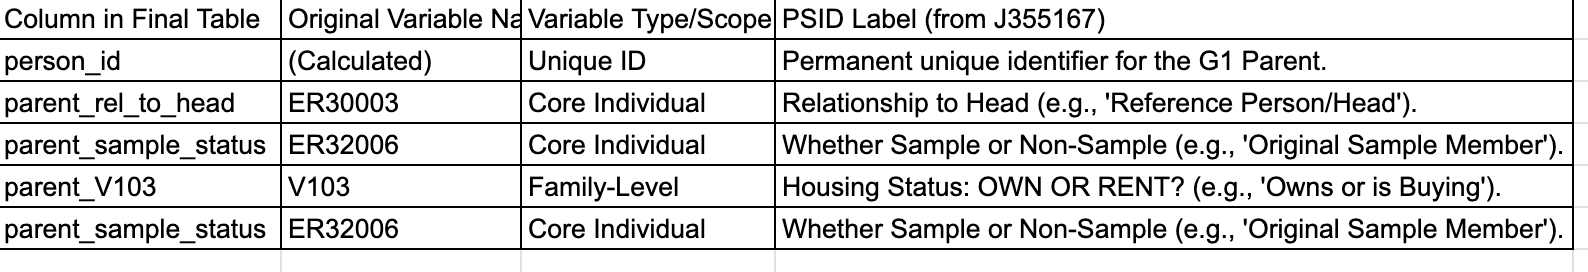

In [62]:
num_unique_g1_entries = fims['parent_id'].nunique()
print(f"There are {num_unique_g1_entries} different G1 entries.")

There are 46648 different G1 entries.


## Look at family unit not just individuals


In [63]:
# Create G1 Family Data by dropping duplicates on the Family ID (ER30001)
# keep='first' means for any family with multiple children, we keep the data
# corresponding to the first child/parent pair encountered in the DataFrame.
g1_family_data_all_vars = final_merged_data.drop_duplicates(
    subset=['ER30001'],
    keep='first'
).copy()

In [64]:
num_unique_members_g1_family = g1_family_data_all_vars['person_id'].nunique()
print(f"There are {num_unique_members_g1_family} unique members in g1_family_data_all_vars.")

There are 8034 unique members in g1_family_data_all_vars.


In [65]:
print(g1_family_data_all_vars.columns.tolist())

['person_id', 'ER30000', 'ER30001', 'ER30002', 'ER32000', 'parent_sample_status', 'V1', 'parent_V103', 'parent_rel_to_head', 'V441', 'V593', 'ER30020', 'ER30021', 'ER30022', 'V1101', 'V1264', 'ER30043', 'ER30044', 'ER30045', 'V1801', 'V1967', 'ER30067', 'ER30068', 'ER30069', 'V2401', 'V2566', 'ER30091', 'ER30092', 'ER30093', 'V3001', 'V3108', 'ER30117', 'ER30118', 'ER30119', 'V3401', 'V3522', 'ER30138', 'ER30139', 'ER30140', 'V3801', 'V3939', 'ER30160', 'ER30161', 'ER30162', 'V4301', 'V4450', 'ER30188', 'ER30189', 'ER30190', 'V5201', 'V5364', 'ER30217', 'ER30218', 'ER30219', 'V5701', 'V5864', 'ER30246', 'ER30247', 'ER30248', 'V6301', 'V6479', 'ER30283', 'ER30284', 'ER30285', 'V6901', 'V7084', 'ER30313', 'ER30314', 'ER30315', 'V7501', 'V7675', 'ER30343', 'ER30344', 'ER30345', 'V8201', 'V8364', 'ER30373', 'ER30374', 'ER30375', 'V8801', 'V8974', 'ER30399', 'ER30400', 'ER30401', 'V10001', 'V10437', 'ER30429', 'ER30430', 'ER30431', 'V11101', 'V11618', 'ER30463', 'ER30464', 'ER30465', 'V1250

In [66]:
g1_family_data_all_vars.head()

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
0,1001,1,1,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
5,2001,1,2,1,1,1,3.0,NaN,1,3.0,5.0,592,1,1,3.0,5.0,415,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
21,3001,1,3,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,593,1,1,3.0,1.0,338,1,1,3.0,1.0,23,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
23,4001,1,4,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,2007,1,1,3.0,8.0,53,1,1

In [67]:
g1_family_data_all_vars.tail()

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
90834,9304001,1,9304,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,1.0,9516,1,10,4.0,1.0,4838,1,10,6.0,1.0,3842,1,10,6.0,1.0,5082,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9304003.0,0.0,1.0,NaN
90838,9305001,1,9305,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,5.0,9045,1,10,4.0,5.0,9041,1,10,6.0,5.0,3843,1,10,6.0,5.0,3391,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9305003.0,0.0,1.0,NaN
90846,9306001,1,9306,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,1.0,9046,1,10,4.0,1.0,9678,1,10,6.0,1.0,3844,1,10,6.0,1.0,6599,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9306003.0,0.0,1.0,NaN
90856,9307001,1,9307,1,

# Export data

In [71]:
fims_links[["parent_id","child_id"]]...


SyntaxError: invalid syntax (ipython-input-923641324.py, line 1)

In [70]:
--- FINAL EXPORTS (used by downstream analysis notebooks) ---

fims_links[["parent_id", "child_id"]] \
    .drop_duplicates() \
    .to_csv("fims_parent_child_edges.csv", index=False)


SyntaxError: invalid syntax (ipython-input-1370570067.py, line 1)

In [69]:
# --- FINAL EXPORT (used by downstream analysis notebooks) ---

edges[["parent_id", "child_id"]] \
    .drop_duplicates() \
    .to_csv("fims_parent_child_edges.csv", index=False)


NameError: name 'edges' is not defined